Cat labels = 97, Dog labels = 101. <- Indicates mislabeling, supposed to be 99 of each!


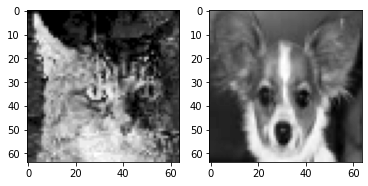

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

catsndogs = pd.read_csv('data\CATSnDOGS.csv')
labels = pd.read_csv('data\Labels.csv')



### Some exploration...

In [ ]:

cat_ids = np.nonzero(labels.values[:,0]==0)[0] #[0] to get into tuple
dog_ids = np.nonzero(labels.values[:,0]==1)[0]

print(f'Cat labels = {len(cat_ids)}, Dog labels = {len(dog_ids)}. <- Indicates mislabeling, supposed to be 99 of each!')

catid = np.random.choice(cat_ids)
dogid = np.random.choice(dog_ids)

cat = catsndogs.iloc[catid].to_numpy().reshape((64,64), order='F')
dog = catsndogs.iloc[dogid].to_numpy().reshape((64,64), order='F')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cat, cmap='gray')
axs[1].imshow(dog, cmap='gray')
plt.show()


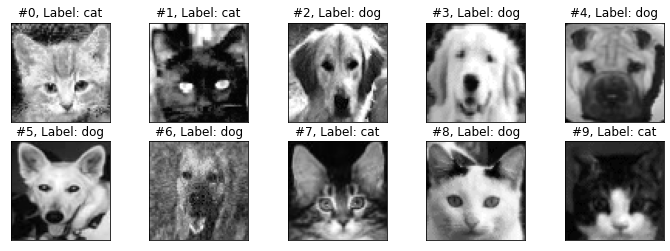

In [2]:
names = ['cat', 'dog']

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))

for i, axr in enumerate(axs):
    for j, ax in enumerate(axr):
        ax.imshow(catsndogs.iloc[i*len(axr)+j].to_numpy().reshape((64,64), order='F'), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'#{i*len(axr)+j}, Label: {names[labels.values[i*len(axr)+j,0]]}')

# Question 1 (60p)



## 1a (10p)
 - Are the cats and dogs well separated, i.e. can you obtain good classification test accuracy performance on this data set? Compare at least 3 classifiers.

 - Are there any images that are consistently mislabeled by the classifiers (use resampling to ascertain)? Why do you think these are difficult images to classify? Do the classifiers struggle with the same observations?

 - Are the errors balanced or is one class more difficult to classify correctly?

In [318]:
# First we try to classify, using 3 classifiers
# Maybe Linear regression, QDA(?), and kNN?

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def analyze_separation(data, labels, repetitions=20, return_train=False):
    test_accuracies = {
        'knn': 0,
        'lr': 0,
        'rf': 0
    }

    train_accuracies = {
        'knn': 0,
        'lr': 0,
        'rf': 0
    }

    test_mislab = {
        'knn': [],
        'lr': [],
        'rf': []
    }

    train_mislab = {
        'knn': [],
        'lr': [],
        'rf': []
    }

    if type(labels)==np.ndarray:
        print('yes')
        labels = pd.DataFrame(labels)

    
    knn = KNeighborsClassifier(n_neighbors=7)
    lr = LogisticRegression(max_iter=500)
    rf = RandomForestClassifier()
        
    for i in range(repetitions):
        x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

        # kNN
        knn.fit(x_train, y_train.values[:,0])
        knn_y_pred = knn.predict(x_test)
        test_accuracies['knn'] += np.sum(knn_y_pred==y_test.values[:,0])/len(y_test) /repetitions
        test_mislab['knn'].extend(y_test.index[(knn_y_pred!=y_test.values[:,0])].to_list())

        # Linear regression
        lr.fit(x_train, y_train.values[:,0])
        lr_y_pred = lr.predict(x_test)
        test_accuracies['lr'] += np.sum(lr_y_pred==y_test.values[:,0])/len(y_test) /repetitions
        test_mislab['lr'].extend(y_test.index[(lr_y_pred!=y_test.values[:,0])].to_list())

        # Random forest
        rf.fit(x_train, y_train.values[:,0])
        rf_y_pred = rf.predict(x_test)
        test_accuracies['rf'] += np.sum(rf_y_pred==y_test.values[:,0])/len(y_test) /repetitions
        test_mislab['rf'].extend(y_test.index[(rf_y_pred!=y_test.values[:,0])].to_list())

        if return_train:
            knn_t_p = knn.predict(x_train)
            lr_t_p = lr.predict(x_train)
            rf_t_p = rf.predict(x_train)
            train_accuracies['knn'] += np.sum(knn_t_p==y_train.values[:,0])/len(y_train) /repetitions
            train_accuracies['lr'] += np.sum(lr_t_p==y_train.values[:,0])/len(y_train) /repetitions
            train_accuracies['rf'] += np.sum(rf_t_p==y_train.values[:,0])/len(y_train) /repetitions

            train_mislab['knn'].extend(y_train.index[(knn_t_p!=y_train.values[:,0])].to_list())
            train_mislab['lr'].extend(y_train.index[(lr_t_p!=y_train.values[:,0])].to_list())
            train_mislab['rf'].extend(y_train.index[(rf_t_p!=y_train.values[:,0])].to_list())


    print(test_accuracies)
    if return_train:
        return test_accuracies, train_accuracies, test_mislab, train_mislab
    else:
        return test_accuracies, test_mislab

test_accuracies, test_mislab = analyze_separation(catsndogs, labels, 20)

{'knn': 0.7749999999999999, 'lr': 0.7587499999999999, 'rf': 0.74375}


consistently mislabeled indices:  [  8  21  37  53  85  93 112 113 114 117 125 151 158 171 176 177 180]
Fraction of dogs in the set of images mislabeled more than 2 times by one or more model:
0.6470588235294118


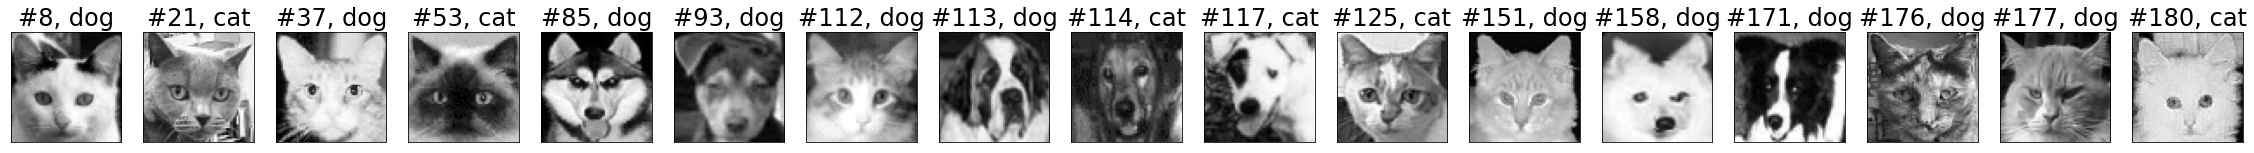

In [309]:
def find_mislabeling(mislabeled, consistency_threshold=2, verbose=False):

    occurences = {}
    combined = np.array([])

    for key in mislabeled.keys():
        occurences[key] = np.bincount(mislabeled[key])
        tmp = np.array(mislabeled[key])
        combined = np.append(combined, np.unique(tmp[occurences[key][tmp]>consistency_threshold])).astype(int)

    consistent_mislabels = np.argwhere(np.bincount(combined)>2).flatten()   # >2 to make it all three models
    if verbose:
        print('consistently mislabeled indices: ', consistent_mislabels)
    
    # Visualize mislabeled images
    fig, axs = plt.subplots(nrows=1, ncols=len(consistent_mislabels), figsize=(40,8))
    for i, label in enumerate(consistent_mislabels):
        axs[i].imshow(catsndogs.iloc[label].to_numpy().reshape((64,64), order='F'), cmap='gray')
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
        axs[i].set_title(f'#{label}, {names[labels.values[label,0]]}', fontsize=24)

    # Are the errors balanced?
    if verbose:
        print(f'Fraction of dogs in the set of images mislabeled more than {consistency_threshold} times by one or more model:\n{np.sum(labels.values[consistent_mislabels,0])/len(labels.values[consistent_mislabels,0])}')
    
    return consistent_mislabels


consistent_mislabels = find_mislabeling(mislabeled, verbose=True)

In [204]:
len(consistent_mislabels)

11

For kNN with k=5 we get 0.75, logistic regression we get 0.74, and random forest gives 0.71. This is better than random, but not particularly good.

Some images are quite consistently mislabeled. If we consider being mislabeled by all three classifiers more than twice out of 20 repetitions consistent, there are about 18 consistently mislabeled images. (9/18 mislabeled images, some dogs that have cat-like ears) However, despite 80/20 train/test split no images seem to be close to being mislabeled near 80% of the time, the most is around 20-50%     --(???)--

The errors are imbalanced, out of the consistently mislabeled images about 80% were labeled as "dog", although some where mislabeled. 

## 1b (10p)
 - Identify the most important pixels for classification - are these easy to identify or is there uncertainty in the selection of important features? Compare at least 3 methods for selecting/identifying features. Note, does not need to be the same methods as in 1a. Can you think of a way to improve on the stability of selection/identification?

 - Can you explain why these pixels are selected/are deemed important?

 - Do the identified predictive features differ between the classification methods?

In [41]:
# Logisticregression CV
# Train model on full dataset - get coef to make correct model

x = catsndogs.to_numpy()
y = labels.values[:,0]

lrCV = LogisticRegressionCV(Cs=np.logspace(-4, 4, 30), multi_class='ovr', solver='liblinear', penalty='l1', intercept_scaling=1000, scoring='accuracy').fit(x, y)

#lrCV = LogisticRegressionCV(Cs=hp, cv=n_folds, scoring='f1', penalty='l1', multi_class='ovr', solver='liblinear', intercept_scaling=10000).fit(x, y)

print(lrCV.C_)


[1.3738238]


In [63]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

repetitions = 50

lr = LogisticRegression(C=lrCV.C_[0], multi_class='ovr', solver='liblinear', penalty='l1')
lr_coefs = np.empty(shape=(repetitions, len(x[0])))

rf = RandomForestClassifier()
rf_coefs = np.empty(shape=(repetitions, len(x[0])))

lda = LinearDiscriminantAnalysis()
lda_coefs = np.empty(shape=(repetitions, len(x[0])))

for i in range(repetitions):
    if i % 50 == 0:
        print(f'bootstrap {i}')
    # Choose n random points
    idxs = np.random.choice(len(y), size=len(y), replace=True)
    x_tmp = x[idxs]
    y_tmp = y[idxs]

    # Fit model to points
    lr.fit(x_tmp, y_tmp)
    rf.fit(x_tmp, y_tmp)
    lda.fit(x_tmp, y_tmp)

    # Get coefficients to see most important features
    lr_coefs[i,:] = lr.coef_[0]
    rf_coefs[i,:] = rf.feature_importances_
    lda_coefs[i,:] = lda.coef_[0]

lda_coefs_mean = np.mean(lda_coefs, axis=0)
lr_coefs_mean = np.mean(lr_coefs, axis=0)
rf_coefs_mean = np.mean(rf_coefs, axis=0)



bootstrap 0


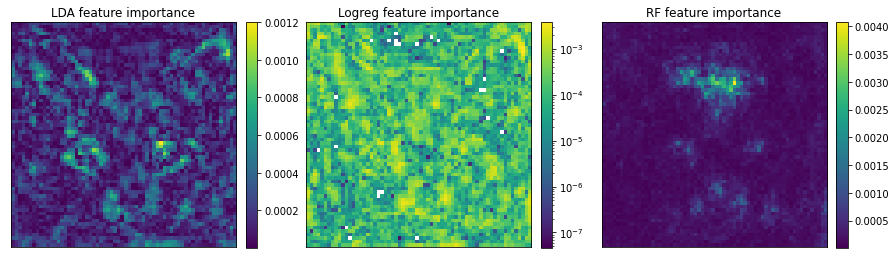

In [69]:
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

lda_importance = lda_coefs_mean.reshape((64,64), order='F')
im0 = axs[0].imshow(np.abs(lda_importance))
axs[0].set_title('LDA feature importance')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

lr_importance = lr_coefs_mean.reshape((64,64), order='F')
im1 = axs[1].imshow(np.abs(lr_importance), norm=LogNorm())
axs[1].set_title("Logreg feature importance")

fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

rf_importance = rf_coefs_mean.reshape((64,64), order='F')
im2 = axs[2].imshow(rf_importance)
axs[2].set_title('RF feature importance')
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

for ax in axs:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


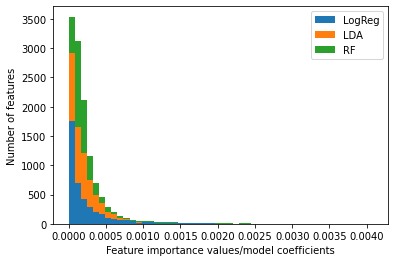

[1711  695  428  281  198  174  101   92   71   51   48   30   25   29
   24   16   20   18    9    8    6   11    9    8    6    3    2    3
    0    2    2    5    2    2    0    1    0    1    0    1    0    0
    0    1    0    0    0    0    0    2]


<ErrorbarContainer object of 3 artists>

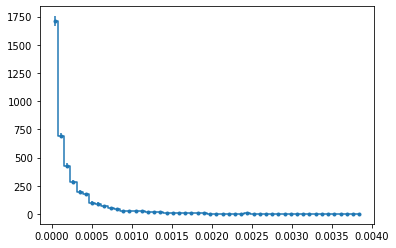

In [203]:
# Histograms
fig, ax = plt.subplots(nrows=1, ncols=1)

hist_data = np.stack([np.abs(lr_coefs_mean), np.abs(lda_coefs_mean), rf_coefs_mean], axis=-1)
ax.hist(hist_data, bins=50, histtype='bar', stacked=True, fill=True)
#ax.set_yscale('log')
ax.set_ylabel('Number of features')
ax.set_xlabel('Feature importance values/model coefficients')
plt.legend(['LogReg', 'LDA', 'RF'])
plt.show()

fig2, ax = plt.subplots(nrows=1, ncols=1)

y, bin_edges = np.histogram(np.abs(lr_coefs_mean), bins=50)     # TODO göra en för varje?
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])

print(y)

plt.errorbar(bin_centers, y, yerr= y**0.5, marker  ='.', drawstyle='steps-mid')

## 1c (10p)
Cluster the data set. Do the clusters agree with the class labels? Does changing the number of clusters have an impact on the overlap with the class labels?

What characteristics of the data does the clustering pick up?

Please think carefully about how you go about this question - how do you choose your input (e.g. do you perform preprocessing or not) to the clustering algorithm? what method and settings? Is it as clear cut how to make these choices if you didn't know the labels?

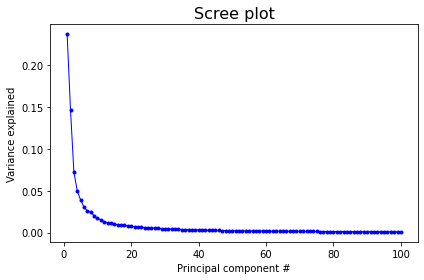

In [112]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
p_comps = pca.fit_transform(catsndogs)

principal_df = pd.DataFrame(p_comps)
combined_df = pd.concat([ labels['x'], principal_df], axis=1)

plt.plot(np.arange(pca.n_components_)+1, pca.explained_variance_ratio_, marker='o', markerfacecolor='blue', markersize=3, color='blue', linewidth=1)
plt.title('Scree plot',fontsize=16)
plt.xlabel('Principal component #')
plt.ylabel('Variance explained')
plt.tight_layout()
plt.show()


     x            0            1            2            3            4  \
0    0 -2731.106062  1403.814591   329.445998   767.707129  1302.724189   
1    0   637.649951 -1206.936306  -796.214295 -1410.718668   336.025905   
2    1 -1371.674206 -1438.013968  -289.873204   -85.099626  -634.403798   
3    1 -3458.994358  -771.788478  1399.494883  1299.372230  -956.657650   
4    1   952.879710 -1635.884918   211.876922  -870.592286  -504.636243   
..  ..          ...          ...          ...          ...          ...   
193  0 -1534.304974 -1231.017980 -1753.035020   221.652396  1382.992514   
194  1   571.834881  -863.798556  -972.476324  -494.472433   964.198976   
195  1  2067.930014  -494.753661  2394.640099 -1029.886232   216.210865   
196  0    76.741473  1555.343506  -487.795214   564.812738    -3.030355   
197  0  1987.318373   825.031138  -248.817787  1644.325362 -1805.290819   

               5            6            7           8  ...          90  \
0    -691.424923   985.8

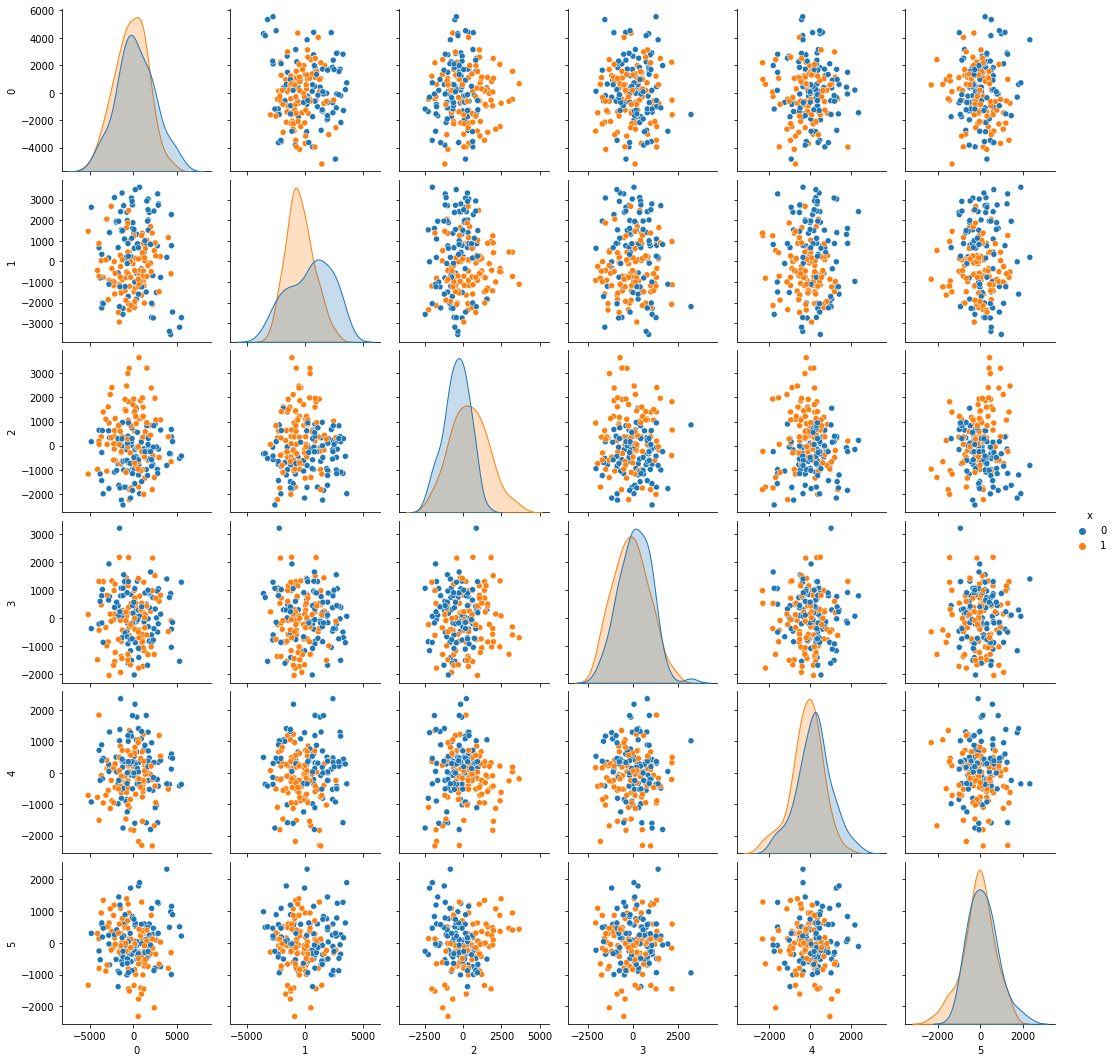

In [113]:
import seaborn as sns
print(combined_df.loc[:, :pca.n_components_-1])
sns.pairplot(combined_df.loc[:, :5], hue='x')

Text(33.0, 0.5, 'True label')

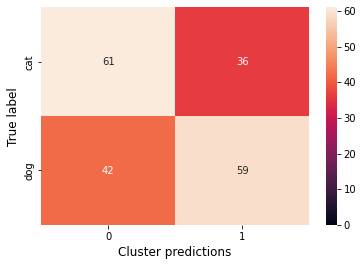

In [185]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

km = KMeans(n_clusters=2).fit(normalize(catsndogs))

conf_mat = confusion_matrix(labels.values, km.labels_)

s = sns.heatmap(conf_mat, annot=True, vmin=0, yticklabels=['cat', 'dog'])
s.set_xlabel('Cluster predictions', fontsize=12)
s.set_ylabel('True label', fontsize=12)


Idéer för att se hur väl kluster överensstämmer:
 - För bara n=2 funkar confusion matrix eller nån manuell beräkning som jag har för mig att jag gjort tidigare
 - Göra bar plots som i project 2? dvs Anta att majoriteten i det predictade klustret är "korrekt" och resten blir overlap(?) Blir ju typ vad de frågar efter, men känns inte så proffsigt/korrekt liksom. Går typ att kika på med skeva (2x3/4) confusion matrix som ovan men inte heller dunder

## 1d (10p)
Cluster the cat and dog data sets separately. How many clusters are there in the cat data? what about the dogs?

Are these the same or differ? Can you think of why? What characterstics of the data do the respective clusterings represent?

In [179]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def score_n_clusters(data, max_n, reps):
    
    sil = np.empty(shape=(max_n-2, reps))
    ch = np.empty(shape=(max_n-2, reps))
    db = np.empty(shape=(max_n-2, reps))

    for n in n_range:
        for i in range(reps):
            km = KMeans(n_clusters=n).fit(data)
            sil[n-2,i] = silhouette_score(data, km.labels_)
            ch[n-2,i] = calinski_harabasz_score(data, km.labels_)
            db[n-2,i] = davies_bouldin_score(data, km.labels_)
        
    sil = sil/np.max(sil)
    ch = ch/np.max(ch)
    db = db/np.max(db)


    fig = plt.figure()
    ax = fig.gca()

    ax.plot(n_range, np.mean(sil, axis=1), label='Silhoutte width')
    ax.fill_between(n_range, np.mean(sil, axis=1)+np.std(sil, axis=1), np.mean(sil, axis=1)-np.std(sil, axis=1), alpha=0.3)

    ax.plot(n_range, np.mean(ch, axis=1), label='Calinski Harabasz')
    ax.fill_between(n_range, np.mean(ch, axis=1)+np.std(ch, axis=1), np.mean(ch, axis=1)-np.std(ch, axis=1), alpha=0.3)

    ax.plot(n_range, np.mean(db, axis=1), label='Davies Bouldin')
    ax.fill_between(n_range, np.mean(db, axis=1)+np.std(db, axis=1), np.mean(db, axis=1)-np.std(db, axis=1), alpha=0.3)

    ax.legend(loc='lower left')

    ax.set_ylabel('Scores scaled to be max 1')
    ax.set_xlabel('Amount of clusters')
    ax.set_xticks(range(2,max_n,2))

    # Blir rätt olika varje gång, kanske average med errorbars
    plt.show()

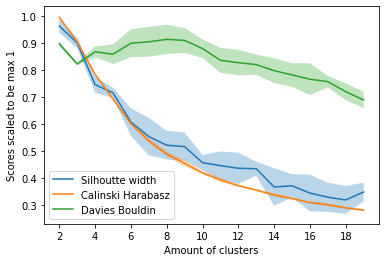

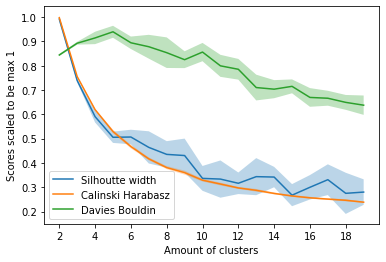

In [180]:
cats = catsndogs[labels.values==0]
dogs = catsndogs[labels.values==1]

max_n = 20
n_range = range(2,max_n)
n_reps = 10

score_n_clusters(cats, max_n, n_reps)
score_n_clusters(dogs, max_n, n_reps)



## 1e (10p)
Use your chosen number of clusters for the cats and dogs (if you selected 1 cluster, use 2 for this task). Rerun task 1a and 1b on the cats data with the cat cluster labels as classes. Rerun tasks 1a and 1b on the dogs data with the dog cluster labels as classes.

Are similar sets of features important for these tasks as in task 1b? Are similar sets of features important for the cat cluster predictions and the dog cluster predictions? Explain why/why not?

In [269]:
km_c = KMeans(n_clusters=2).fit(cats)
cat_labels = km_c.labels_

cat_acc, cat_mislab = analyze_separation(cats, km_c.labels_, repetitions=20)

km_d = KMeans(n_clusters=2).fit(dogs)
dog_labels = km_d.labels_

dog_acc, dog_mislab = analyze_separation(dogs, km_d.labels_, repetitions=20)

yes
{'knn': 0.915, 'lr': 0.7249999999999999, 'rf': 0.9025000000000001}
yes
{'knn': 0.9285714285714286, 'lr': 0.5833333333333334, 'rf': 0.9023809523809523}


### Examples from each cluster, cats and dogs

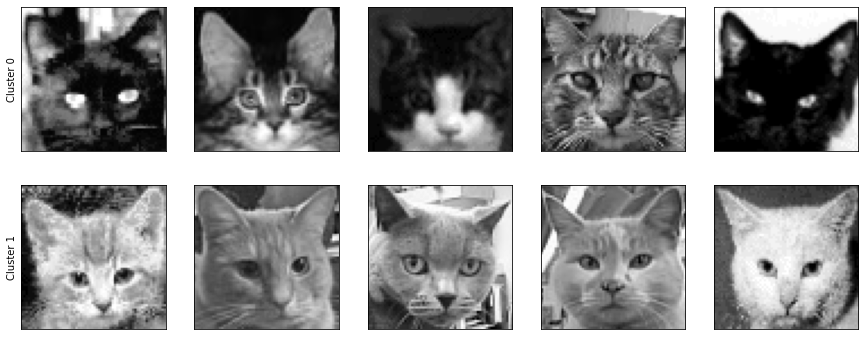

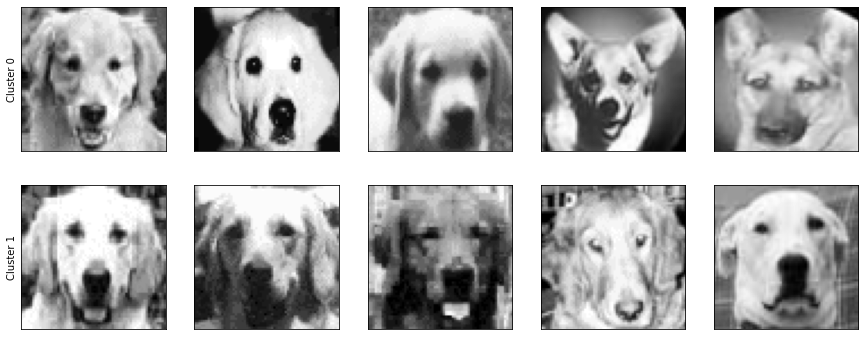

In [254]:
# Showing some examples from each cluster
# Kan vara så att km modellen behöver göras om om man kör denna igen
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,6))
idxs_1 = np.argwhere(km.labels_==0).flatten()
idxs_2 = np.argwhere(km.labels_==1).flatten()

for row in range(2):
    for col in range(5):
        if row==0:
            axs[row,col].imshow(cats.iloc[idxs_1[col]].to_numpy().reshape((64,64), order='F'), cmap='gray')
        elif row==1:
            axs[row,col].imshow(cats.iloc[idxs_2[col]].to_numpy().reshape((64,64), order='F'), cmap='gray')
        
        #axs[row,col].get_xaxis().set_visible(False)
        axs[row,col].set_xticklabels([])
        axs[row,col].set_xticks([])
        axs[row,col].set_yticklabels([])
        axs[row,col].set_yticks([])

axs[0,0].set_ylabel(f'Cluster {0}')
axs[1,0].set_ylabel(f'Cluster {1}')

fig.set_facecolor('white')

plt.show()

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,6))
idxs_1 = np.argwhere(km.labels_==0).flatten()
idxs_2 = np.argwhere(km.labels_==1).flatten()

for row in range(2):
    for col in range(5):
        if row==0:
            axs[row,col].imshow(dogs.iloc[idxs_1[col+5]].to_numpy().reshape((64,64), order='F'), cmap='gray')
        elif row==1:
            axs[row,col].imshow(dogs.iloc[idxs_2[col+5]].to_numpy().reshape((64,64), order='F'), cmap='gray')
        
        #axs[row,col].get_xaxis().set_visible(False)
        axs[row,col].set_xticklabels([])
        axs[row,col].set_xticks([])
        axs[row,col].set_yticklabels([])
        axs[row,col].set_yticks([])

axs[0,0].set_ylabel(f'Cluster {0}')
axs[1,0].set_ylabel(f'Cluster {1}')

fig.set_facecolor('white')

### Vet inte om detta ska med eller om man ska gå rakt på b)?

consistently mislabeled indices:  [10 27 81]


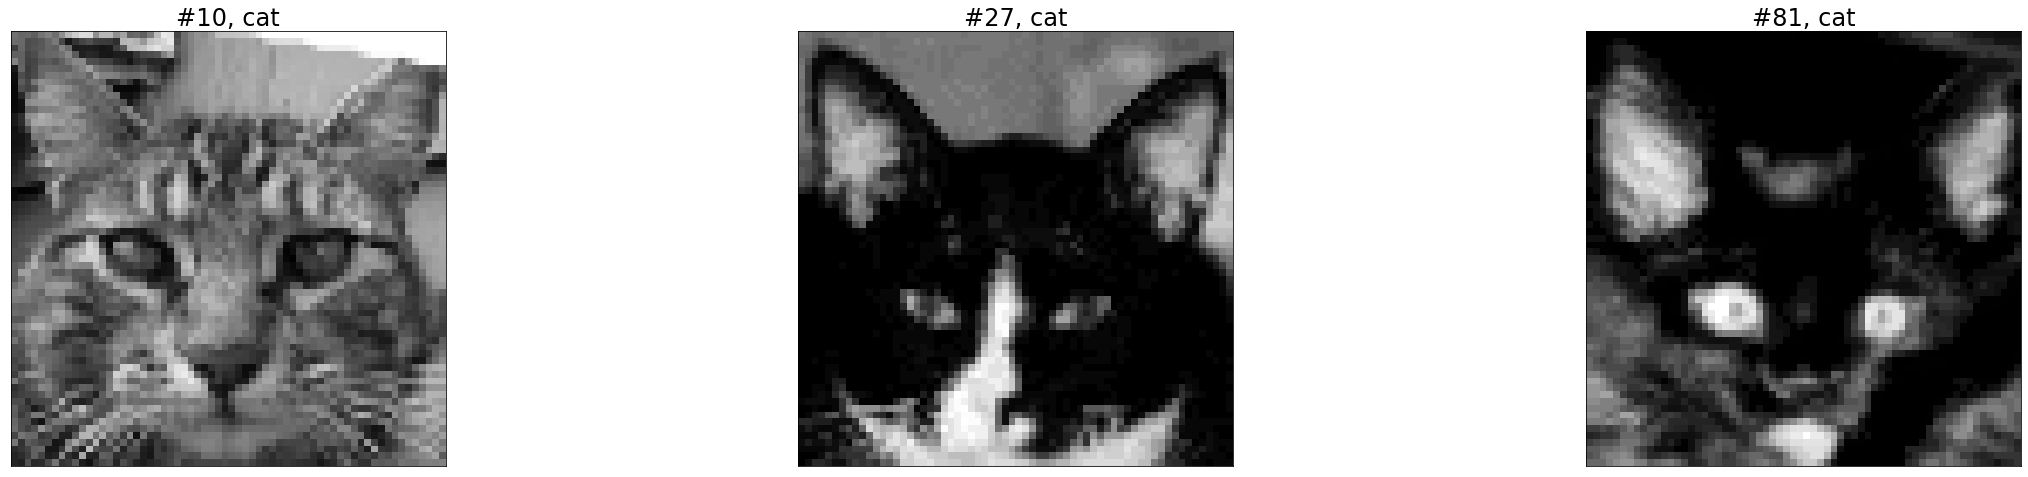

In [225]:
occurences = {}
combined = np.array([])
consistency_threshold = 1

for key in mislab.keys():
    occurences[key] = np.bincount(mislab[key])
    tmp = np.array(mislab[key])
    combined = np.append(combined, np.unique(tmp[occurences[key][tmp]>consistency_threshold])).astype(int)

consistent_mislabels = np.argwhere(np.bincount(combined)>2).flatten()   # >2 to make it all three models
print('consistently mislabeled indices: ', consistent_mislabels)

# Visualize mislab images
fig, axs = plt.subplots(nrows=1, ncols=len(consistent_mislabels), figsize=(40,8))
for i, label in enumerate(consistent_mislabels):
    axs[i].imshow(catsndogs.iloc[label].to_numpy().reshape((64,64), order='F'), cmap='gray')
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    axs[i].set_title(f'#{label}, {names[labels.values[label,0]]}', fontsize=24)

# Are the errors balanced?


### b) part

#### cats

In [261]:

lrCV = LogisticRegressionCV(Cs=np.logspace(-4, 4, 30), multi_class='ovr', solver='liblinear', penalty='l1', intercept_scaling=1000, scoring='accuracy').fit(cats, cat_labels)

print(lrCV.C_)

[0.05736153]


In [265]:
x = cats.to_numpy()
y = cat_labels

repetitions = 50

lr = LogisticRegression(C=lrCV.C_[0], multi_class='ovr', solver='liblinear', penalty='l1')
lr_coefs = np.empty(shape=(repetitions, len(x[0])))

rf = RandomForestClassifier()
rf_coefs = np.empty(shape=(repetitions, len(x[0])))

lda = LinearDiscriminantAnalysis()
lda_coefs = np.empty(shape=(repetitions, len(x[0])))

for i in range(repetitions):
    if i % 50 == 0:
        print(f'bootstrap {i}')
    # Choose n random points
    idxs = np.random.choice(len(y), size=len(y), replace=True)
    x_tmp = x[idxs]
    y_tmp = y[idxs]

    # Fit model to points
    lr.fit(x_tmp, y_tmp)
    rf.fit(x_tmp, y_tmp)
    lda.fit(x_tmp, y_tmp)

    # Get coefficients to see most important features
    lr_coefs[i,:] = lr.coef_[0]
    rf_coefs[i,:] = rf.feature_importances_
    lda_coefs[i,:] = lda.coef_[0]

lda_coefs_mean = np.mean(lda_coefs, axis=0)
lr_coefs_mean = np.mean(lr_coefs, axis=0)
rf_coefs_mean = np.mean(rf_coefs, axis=0)

bootstrap 0


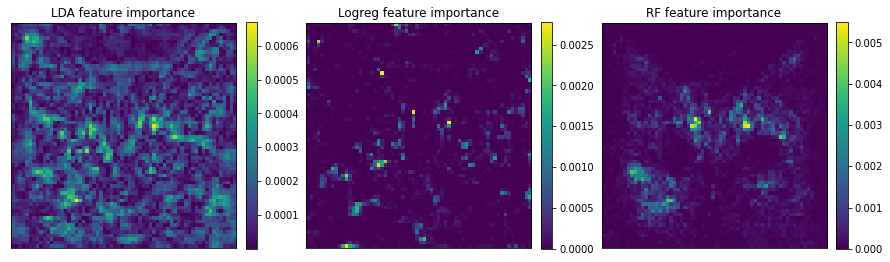

In [267]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

lda_importance = lda_coefs_mean.reshape((64,64), order='F')
im0 = axs[0].imshow(np.abs(lda_importance))
axs[0].set_title('LDA feature importance')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

lr_importance = lr_coefs_mean.reshape((64,64), order='F')
im1 = axs[1].imshow(np.abs(lr_importance))
axs[1].set_title("Logreg feature importance")

fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

rf_importance = rf_coefs_mean.reshape((64,64), order='F')
im2 = axs[2].imshow(rf_importance)
axs[2].set_title('RF feature importance')
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

for ax in axs:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

#### dogs

In [270]:
lrCV = LogisticRegressionCV(Cs=np.logspace(-4, 4, 30), multi_class='ovr', solver='liblinear', penalty='l1', intercept_scaling=1000, scoring='accuracy').fit(dogs, dog_labels)

print(lrCV.C_)

[0.03039195]


In [271]:
x = dogs.to_numpy()
y = dog_labels

repetitions = 50

lr = LogisticRegression(C=lrCV.C_[0], multi_class='ovr', solver='liblinear', penalty='l1')
lr_coefs = np.empty(shape=(repetitions, len(x[0])))

rf = RandomForestClassifier()
rf_coefs = np.empty(shape=(repetitions, len(x[0])))

lda = LinearDiscriminantAnalysis()
lda_coefs = np.empty(shape=(repetitions, len(x[0])))

for i in range(repetitions):
    if i % 50 == 0:
        print(f'bootstrap {i}')
    # Choose n random points
    idxs = np.random.choice(len(y), size=len(y), replace=True)
    x_tmp = x[idxs]
    y_tmp = y[idxs]

    # Fit model to points
    lr.fit(x_tmp, y_tmp)
    rf.fit(x_tmp, y_tmp)
    lda.fit(x_tmp, y_tmp)

    # Get coefficients to see most important features
    lr_coefs[i,:] = lr.coef_[0]
    rf_coefs[i,:] = rf.feature_importances_
    lda_coefs[i,:] = lda.coef_[0]

lda_coefs_mean = np.mean(lda_coefs, axis=0)
lr_coefs_mean = np.mean(lr_coefs, axis=0)
rf_coefs_mean = np.mean(rf_coefs, axis=0)

bootstrap 0


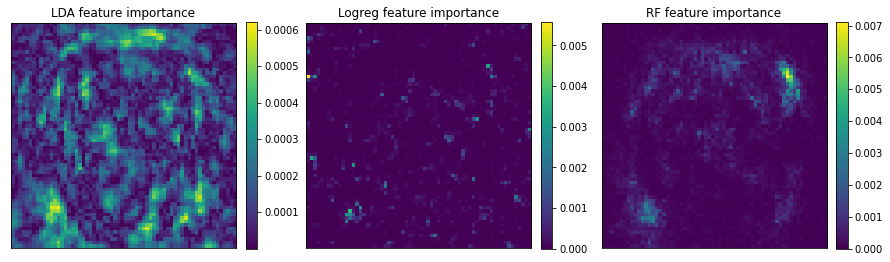

In [274]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

lda_importance = lda_coefs_mean.reshape((64,64), order='F')
im0 = axs[0].imshow(np.abs(lda_importance))
axs[0].set_title('LDA feature importance')
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

lr_importance = lr_coefs_mean.reshape((64,64), order='F')
im1 = axs[1].imshow(np.abs(lr_importance))
axs[1].set_title("Logreg feature importance")

fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

rf_importance = rf_coefs_mean.reshape((64,64), order='F')
im2 = axs[2].imshow(rf_importance)
axs[2].set_title('RF feature importance')
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

for ax in axs:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Question 2 (60p)


We will continue to work with the Cats and Dogs data set but now use simulations to investigate how feature selection and classification can be affected by various kinds of noise contamination. Here the focus is on cats vs dog prediction.

Since the tasks below are simulation based you will need to repeat the task for multiple runs and also compare to the noise free results for reference.

## 2a (10p)


Add random noise to a randomly selected subset of images. That is, change the pixel value from the original to something else but still in the [0,256] range and in such a fashion that you control how much noise are added (how much you change the original pixel value).

Vary the noise level (at least 2 levels) and the number of affected images (at least 3 levels). How does a subset of noisy images affect the overall classification performance?

Are the noisy images over-represented as those that are misclassified (training error and test error)?

Noise std: 5, on 25 images
{'knn': 0.735, 'lr': 0.78, 'rf': 0.7100000000000001}
Noisy and mislabeled: [125 151 176]
Frequency of noisy images being mislabeled: 0.21428571428571427
Frequency of noisy images: 0.12626262626262627
Noise std: 5, on 50 images
{'knn': 0.77, 'lr': 0.77, 'rf': 0.75}
Noisy and mislabeled: [ 53  58  78  85 112 117]
Frequency of noisy images being mislabeled: 0.42857142857142855
Frequency of noisy images: 0.25252525252525254
Noise std: 5, on 75 images
{'knn': 0.78, 'lr': 0.7849999999999999, 'rf': 0.76}
Noisy and mislabeled: [ 85  90  93 114 117]
Frequency of noisy images being mislabeled: 0.35714285714285715
Frequency of noisy images: 0.3787878787878788
Noise std: 25, on 25 images
{'knn': 0.75, 'lr': 0.7350000000000001, 'rf': 0.73}
Noisy and mislabeled: [176]
Frequency of noisy images being mislabeled: 0.07142857142857142
Frequency of noisy images: 0.12626262626262627
Noise std: 25, on 50 images
{'knn': 0.76, 'lr': 0.78, 'rf': 0.79}
Noisy and mislabeled: [ 90  93 

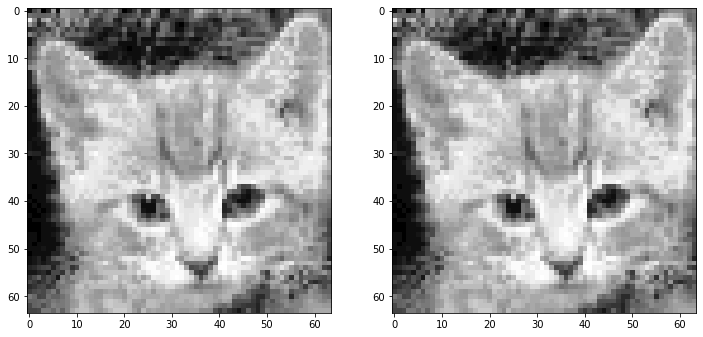

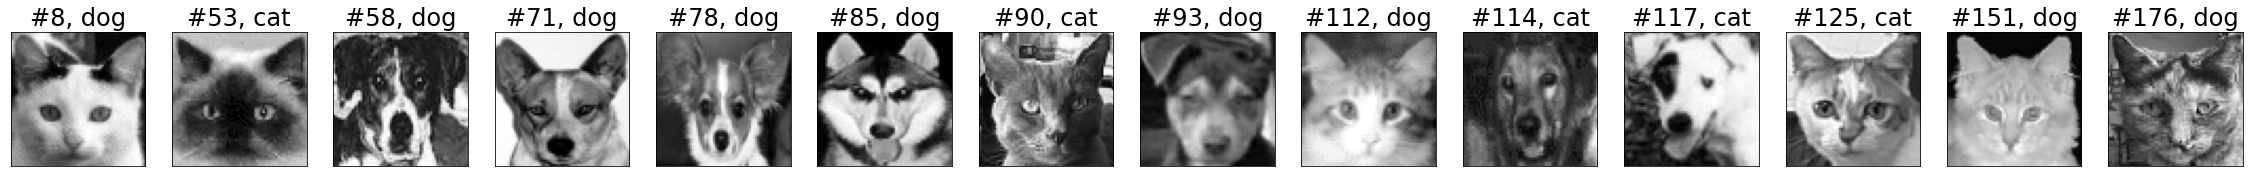

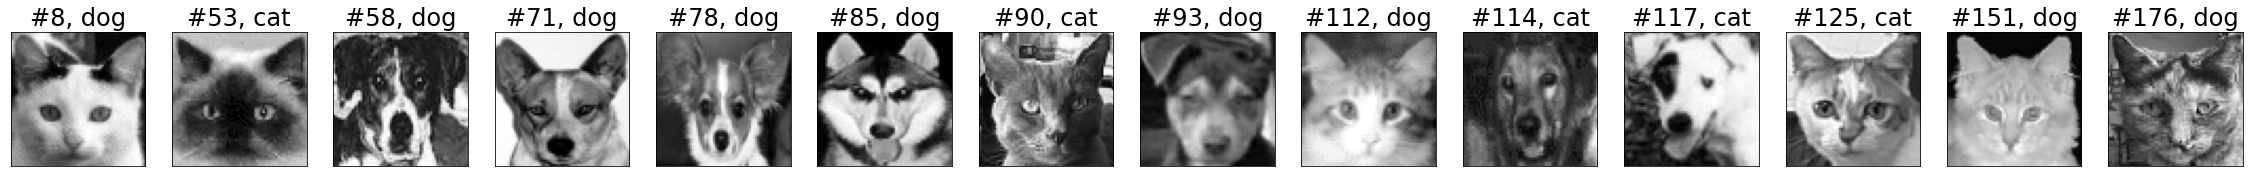

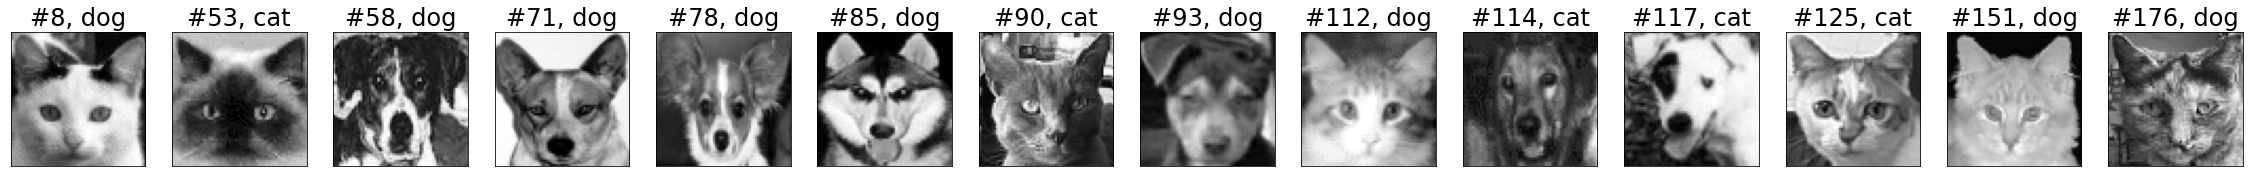

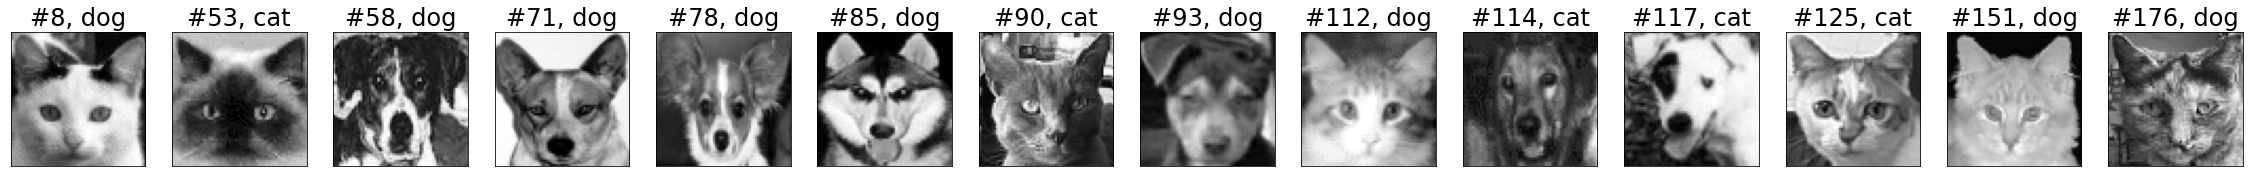

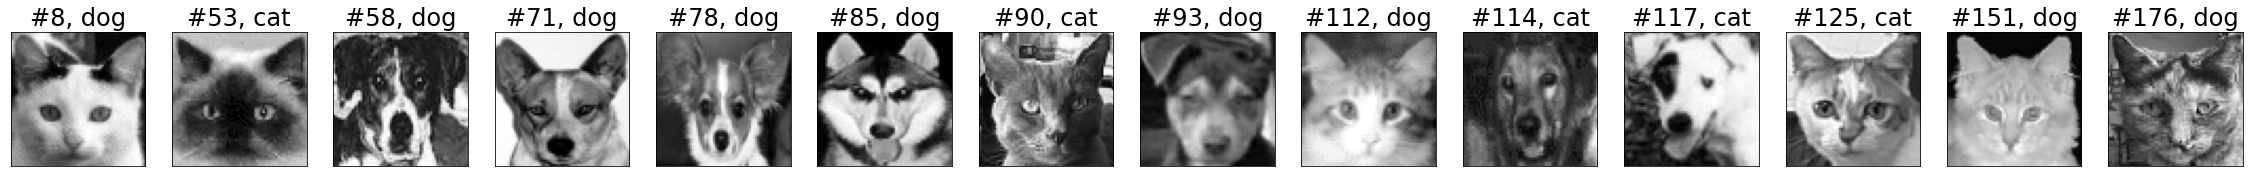

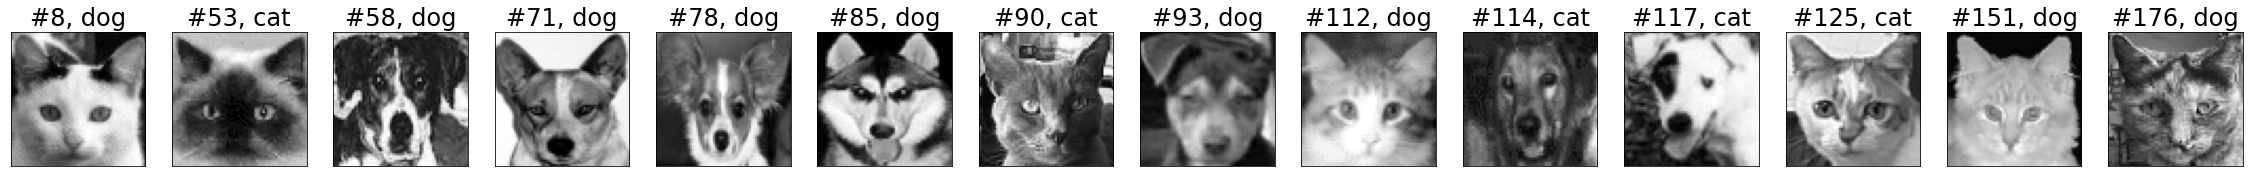

In [319]:
from copy import deepcopy

noise_levels = [5, 25]
ns_affected = [25,50,75]

noisy_accs = np.empty(shape=(len(noise_levels), len(ns_affected), 3))
n_freq[i,j] = np.empty(shape=(len(noise_levels), len(ns_affected)))
nm_freq[i,j] = np.empty(shape=(len(noise_levels), len(ns_affected)))

fig, ax = plt.subplots(nrows=1, ncols=len(noise_levels), figsize=(12,6))

for i, noise_lv in enumerate(noise_levels):
    for j, n in enumerate(ns_affected):
        print(f'Noise std: {noise_lv}, on {n} images')
        # Add noise according to level and n affected
        noisy_ids = np.random.choice(catsndogs.index, size=n, replace=False)
        noisy_ims = deepcopy(catsndogs)
        noise = np.random.normal(loc=0, scale=noise_lv, size=4096)
        noisy_ims.iloc[noisy_ids] += noise
        if n == ns_affected[0]:
            ax[i].imshow(noisy_ims.iloc[0].to_numpy().reshape((64,64), order='F'), cmap='gray')

        # How does a subset of noisy images affect the overall classification performance?
        # Kör samma tre 
        noisy_t_acc, noisy_tr_acc, noisy_t_mislab, noisy_tr_mislab = analyze_separation(noisy_ims, labels, repetitions=5, return_train=True)
        for k, key in enumerate(noisy_t_acc.keys()):
            #print(noisy_acc[key])
            #print(noisy_mislab[key])

            noisy_accs[i,j,k] = noisy_t_acc[key]  # accuracy for classifier
            #noisy_mislabs_avg = noisy_mislab[key]    # ids for every mislabeled image by classifier

        cons_t_mislab = find_mislabeling(noisy_t_mislab, consistency_threshold=0)
        # TODO All these are on test, name accordingly and copy for training
        noisy_and_mislabeled = np.intersect1d(cons_t_mislab, noisy_ids)
        print(f'Noisy and mislabeled: {noisy_and_mislabeled}')
        nm_freq[i,j] = len(noisy_and_mislabeled)/len(cons_t_mislab)
        print(f'Frequency of noisy images being mislabeled: {nm_freq[i,j]}')
        n_freq[i,j] = n/198
        print(f'Frequency of noisy images: {n_freq[i,j]}\n')
        # Need to find if the noisy images are over-represented in mislabeled
        # Save frequency of noisy in mislab and compare to n_affected
plt.show()